# Анализ поведения пользователей мобильного приложения

## Подготовка данных к анализу

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
from scipy import stats as st
import math as mth
import seaborn as sns
from plotly import graph_objects as go
import matplotlib.pyplot as plt
import plotly.express as px
from itertools import combinations
import warnings
warnings.filterwarnings("ignore")

In [2]:
try:
    data = pd.read_csv('logs_exp.csv', delim_whitespace=True)
except FileNotFoundError:
    data = pd.read_csv('/datasets/logs_exp.csv', delim_whitespace=True)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Датафрейм состоит из 4 колонок и 244 126 строк. Пропусков нет. 

In [4]:
data.sample(5)

,EventName,DeviceIDHash,EventTimestamp,ExpId
156316,CartScreenAppear,5906188182380881977,1565006978,248
89099,CartScreenAppear,8173190940950873857,1564832605,246
61303,MainScreenAppear,5401153735414945172,1564757007,246
202564,OffersScreenAppear,1721101105509587254,1565107588,247
143450,MainScreenAppear,5132369487098274503,1564982209,246


Переименуем столбцы.

In [5]:
data = data.rename(
    columns={
        'EventName':'event_name', 
        'DeviceIDHash':'user_id', 
        'EventTimestamp':'event_time',
        'ExpId':'group_id'
    })

Преобразуем столбец `event_time` в формат дата и время.

In [6]:
data['event_time'] = pd.to_datetime(data['event_time'], unit='s')

Добавим отдельный столбец с датами.

In [7]:
data['event_date'] = pd.to_datetime(data['event_time']).dt.date.astype('datetime64[ns]')

Проверим на дубликаты.

In [8]:
print(f'Полных дубликатов в данных: {data.duplicated().sum()}')

Полных дубликатов в данных: 413


Удалим дубликаты.

In [9]:
data = data.drop_duplicates()

In [10]:
data['event_name'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

Ошибок в наименованиях событий нет.

**Вывод**

Данные проверены: пропусков не обнаружено, 413 дубликатов удалено. Столбец с данными о дате и времени переведен в удобочитаемый формат, добавлен отдельный столбец с датой, переименованы столбцы.

## Изучение и проверка данных

In [11]:
print(
    f'Всего в логе {len(data)} событий и {data["user_id"].nunique()} пользователей'
)
print(
    f'В среднем на одного пользователя приходится {int(data.groupby("user_id")["event_name"].agg("count").median())} событий'
)

Всего в логе 243713 событий и 7551 пользователей
В среднем на одного пользователя приходится 20 событий


In [12]:
print(f"Минимальная дата {data['event_date'].min()}")
print(f"Максимальная дата {data['event_date'].max()}")

Минимальная дата 2019-07-25 00:00:00
Максимальная дата 2019-08-07 00:00:00


In [13]:
time_diff = data['event_date'].max() - data['event_date'].min()
print(f"Количество дней в данных: {time_diff.days}")

Количество дней в данных: 13


Лог распологает данными с 25 июля по 7 августа 2019 года.

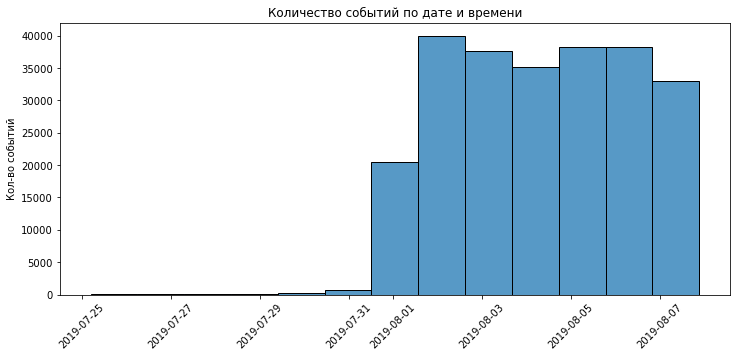

In [14]:
plt.figure(figsize=(12, 5))
sns.histplot(x=data['event_time'], bins=13)
plt.title('Количество событий по дате и времени')
plt.ylabel('Кол-во событий')
plt.xlabel('')
plt.xticks(rotation=45)
plt.show()

Судя по гистограмме, полные данные есть только за август - с 01 по 07.

Уберем неполные данные и посмотрим, сколько событий и пользователей останется в логе.

In [15]:
complete_data = data.query('event_date > "2019-08-01"')

In [16]:
print(
    f'Всего в логе осталось {len(complete_data)} событий и {complete_data["user_id"].nunique()} пользователей'
)
print(
    f'В результате очистки данных было удалено {round((len(data)-len(complete_data))/len(complete_data)*100, 2)}% событий и {round((data["user_id"].nunique()-complete_data["user_id"].nunique())/data["user_id"].nunique()*100, 2)}% пользователей'
)
print(
    f'После очистки данных в среднем на одного пользователя приходится {int(complete_data.groupby("user_id")["event_name"].agg("count").median())} событий'
)

Всего в логе осталось 204746 событий и 7286 пользователей
В результате очистки данных было удалено 19.03% событий и 3.51% пользователей
После очистки данных в среднем на одного пользователя приходится 17 событий


Убедимся, что в логе есть пользователи из всех трех групп.

In [17]:
complete_data.groupby('group_id')['user_id'].nunique()

group_id
246    2393
247    2434
248    2459
Name: user_id, dtype: int64

Все три группы на месте, во всех примерно одинаковое количество уникальных пользователей.

**Вывод**

Данные были проверены на полноту. В результате очистки от неполных данных были оставлены собития за август 2019 года с 01 по 07 число и было удалено 38967 событий и 265 пользователей. Всего в логе осталось 204746 событий и 7286 пользователей, в среднем на одного пользователя приходится 17 событий.

## Воронка событий

Посмотрим, какие события и как часто встречаются в логе и посчитаем для каждого события количество уникальных пользователей, а так же долю пользователей, совершивших хотя бы одно событие.

In [18]:
events = (
    complete_data.groupby('event_name')['user_id']
    .agg(['count', 'nunique'])
    .sort_values(by='count', ascending=False)
    .reset_index()
)
events = events.rename(columns={'count':'events_numb', 'nunique':'users_unique'})
events.assign(cr=lambda row: round(row['users_unique'] / data["user_id"].nunique() * 100, 2))

,event_name,events_numb,users_unique,cr
0,MainScreenAppear,99383,7156,94.77
1,OffersScreenAppear,39345,4380,58.01
2,CartScreenAppear,36086,3571,47.29
3,PaymentScreenSuccessful,29147,3399,45.01
4,Tutorial,785,690,9.14


* Самое частое событие это отображение главного экрана, оно происходило 99 383 раза.
* Второе по частоте событие это отображение экрана с каталогом товаров - 39 345 раз.
* Третье событие это отображение экрана с корзиной - 36 086 раз.
* Четвёртое событие это отображение экрана с подтверждением оплаты - оно случалось 29 147 раз.
* Самое редкое событие - отображение странички с FAQ случалось 785 раз.

Предположим последовательность событий, пользователь видит:

- главный экран
- экран с товарами
- корзину
- подтверждение успешной оплаты

Реже всего пользователь видит:
- страничку с FAQ

Страничка с FAQ может открываться пользователем на любом этапе и не входит в последовательную цепочку событий, при построении воронки не будем учитывать это событие.

In [19]:
clear_events = events.query('event_name != "Tutorial"')

In [33]:
fig = go.Figure()
fig.add_trace(go.Funnel(
    y = clear_events['event_name'], 
    x = clear_events['users_unique'],
    textinfo = "value+percent initial"))
fig.update_layout(title="Воронка событий")
fig.show()

Визуализация воронки нам показывает, что с главной страницы в каталог товаров добираются 61,2% пользователей. Из каталога в корзину переходит 81,5% (или 49,9% от пользователей, зашедших на главную страницу). А из корзины к успешной оплате доходят 95,2% или 47,5% тех, кто зашел на главную страницу.

Плучается, что больше всего пользователей (38,8%) отваливается на этапе отображения главной страницы, а с главной страницы до оплаты доходит лишь 47,5%.

**Вывод**

Цепочка событий: 
- пользователь заходит на главную страницу
- переходит в каталог товаров
- переходит в корзину
- покупает товар

Больше всего пользователей отваливаются на 1 этапе, скорее всего, есть какие-то проблемы с главной страницей. На остальных этапах уходит значительно меньше пользователей, что не выглядит чем-то аномальным. От главной страницы до успешной оплаты доходит лишь 47,5% пользователей.

## Анализ результатов эксперимента

Напомним, сколько пользователей в каждой эксперементальной группе:

In [21]:
complete_data.groupby('group_id')['user_id'].nunique()

group_id
246    2393
247    2434
248    2459
Name: user_id, dtype: int64

Проверим, не попали ли одни и те же пользователи в разные группы.

In [22]:
wrong_users = np.intersect1d(complete_data.query('group_id == "246"')['user_id'].unique(), 
                                complete_data.query('group_id == "247"')['user_id'].unique(),
                             complete_data.query('group_id == "248"')['user_id'].unique())
print(f'Количество пользователей, попавших во все три группы:{len(wrong_users)}')

Количество пользователей, попавших во все три группы:0


In [23]:
pair_of_group = list(combinations(['246', '247', '248'], r=2))

In [24]:
for pair in pair_of_group:
    print(pair)
    wrong_users = np.intersect1d(complete_data.query('group_id == @pair[0]')['user_id'].unique(), 
                                complete_data.query('group_id == @pair[1]')['user_id'].unique())
    print(f'Количество пользователей, попавших в обе группы:{len(wrong_users)}')

('246', '247')
Количество пользователей, попавших в обе группы:0
('246', '248')
Количество пользователей, попавших в обе группы:0
('247', '248')
Количество пользователей, попавших в обе группы:0


### Проверка групп на отсутсвие статистически значимой разницы

Есть 2 контрольные группы и одна экпериментальнная для А/А/B-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверим, находят ли статистические критерии разницу между выборками:

* проверку будем осуществлять через z-test
* уровень alpha выберем с учетом поправки Бонферрони 0.05/количество тестов

Посчитаем число пользователей, совершивших событие в каждой из групп. 

In [25]:
clear_events_groups = complete_data.pivot_table(index='event_name',
                                                columns='group_id',
                                                values='user_id',
                                                aggfunc='nunique').sort_values(
                                                    by=246, ascending=False)
clear_events_groups = clear_events_groups.query('event_name != "Tutorial"')
clear_events_groups

group_id,246,247,248
event_name,,,
MainScreenAppear,2355,2392,2409
OffersScreenAppear,1480,1438,1462
CartScreenAppear,1213,1184,1174
PaymentScreenSuccessful,1152,1118,1129


Посчитаем долю пользователей, совершивших событие.

In [26]:
round(clear_events_groups/complete_data.groupby('group_id')['user_id'].nunique()*100, 2)

group_id,246,247,248
event_name,,,
MainScreenAppear,98.41,98.27,97.97
OffersScreenAppear,61.85,59.08,59.46
CartScreenAppear,50.69,48.64,47.74
PaymentScreenSuccessful,48.14,45.93,45.91


In [27]:
clear_events_groups = clear_events_groups.reset_index()

Проверим, будет ли отличие между группами статистически достоверным.

In [28]:
def z_test(event, group_a, group_2, alpha):

    alpha = alpha

    # пропорция успехов в первой группе:
    p1 = clear_events_groups.query(
        "event_name==@event")[group_a] / complete_data.groupby(
            'group_id')['user_id'].nunique()[group_a]

    # пропорция успехов во второй группе:
    p2 = clear_events_groups.query(
        "event_name==@event")[group_2] / complete_data.groupby(
            'group_id')['user_id'].nunique()[group_2]

    # пропорция успехов в комбинированном датасете:
    p_combined = (
        clear_events_groups.query("event_name==@event")[group_a] +
        clear_events_groups.query("event_name==@event")[group_2]) / (
            complete_data.groupby('group_id')['user_id'].nunique()[group_a] +
            complete_data.groupby('group_id')['user_id'].nunique()[group_2])

    # разница пропорций в датасетах
    difference = p1 - p2

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(
        p_combined * (1 - p_combined) *
        (1 / complete_data.groupby('group_id')['user_id'].nunique()[group_a] +
         1 / complete_data.groupby('group_id')['user_id'].nunique()[group_2]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print(f'{event} p-значение: {p_value}')

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        )

In [29]:
for event in clear_events_groups['event_name'].unique():
    for pair in pair_of_group:
        print(event, pair)
        z_test(event, int(pair[0]), int(pair[1]), 0.05/16)

MainScreenAppear ('246', '247')
MainScreenAppear p-значение: [0.70812861]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
MainScreenAppear ('246', '248')
MainScreenAppear p-значение: [0.24511557]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
MainScreenAppear ('247', '248')
MainScreenAppear p-значение: [0.42804175]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
OffersScreenAppear ('246', '247')
OffersScreenAppear p-значение: [0.04929589]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
OffersScreenAppear ('246', '248')
OffersScreenAppear p-значение: [0.08818847]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
OffersScreenAppear ('247', '248')
OffersScreenAppear p-значение: [0.78932242]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
CartScreenAppear ('246', '247')
CartScreenAppear p-значение: [0.15531969]
Не

Статистически значимая разница между выборками отсутствует, разбиение на группы работает корректно.

### Проверка экспериментальной группы с объединенной контрольной

Сравним результаты экспериментальной группы с объединенной контрольной группой по каждому событию.

In [30]:
clear_events_groups['249'] = clear_events_groups[246]+clear_events_groups[247]

In [31]:
for row in clear_events_groups.values:
    
    alpha = 0.05/16

    # пропорция успехов в первой группе:
    p1 = row[4]/(complete_data.groupby('group_id')['user_id'].nunique()[247]+complete_data.groupby('group_id')['user_id'].nunique()[246])

    # пропорция успехов во второй группе:
    p2 = row[3]/complete_data.groupby('group_id')['user_id'].nunique()[248]

    # пропорция успехов в комбинированном датасете:
    p_combined = (row[4] + row[3]) / ((complete_data.groupby('group_id')['user_id'].nunique()[247]+complete_data.groupby('group_id')['user_id'].nunique()[246]) + complete_data.groupby('group_id')['user_id'].nunique()[248])

    # разница пропорций в датасетах
    difference = p1 - p2 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/(complete_data.groupby('group_id')['user_id'].nunique()[247]+complete_data.groupby('group_id')['user_id'].nunique()[246]) + 1/complete_data.groupby('group_id')['user_id'].nunique()[248]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(
        p_combined * (1 - p_combined) * (1 / complete_data.groupby('group_id')['user_id'].nunique()[247] + 1 / complete_data.groupby('group_id')['user_id'].nunique()[248])
    )

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print(f'{row[0]} p-значение: {p_value}')

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        ) 

MainScreenAppear p-значение: 0.3205137558231854
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
OffersScreenAppear p-значение: 0.4765854578515718
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
CartScreenAppear p-значение: 0.1802720785759897
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
PaymentScreenSuccessful p-значение: 0.4347419670174102
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Статистически значимой разницы не выявлено.

Взглянем на воронку по всем трем группам.

In [34]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'Group 246',
    y = clear_events_groups['event_name'],
    x = clear_events_groups[246],
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name = 'Group 247',
    y = clear_events_groups['event_name'],
    x = clear_events_groups[247],
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name = 'Group 248',
    y = clear_events_groups['event_name'],
    x = clear_events_groups[248],
    textinfo = "value+percent initial"))
fig.update_layout(title="Воронка событий")
fig.show()

**Вывод:**

Проверив все три группы и сравних их друг с другом каких-либо значимых различий выявлено не было.

## Вывод

Стартап, продающий продукты питания хотел разобраться, как ведут себя пользователи его мобильного приложения.

В ходе исследования: 
- проведена предобработка и подготовка данных
- изучена воронка продаж
- выстроена цепочка событий
- исследованы результаты A/A/B-эксперимента
- выяснено, какой шрифт лучше

Подробнее:

Для целей исследования были взятые данные с 01.08.2019 по 07.08.2019, так как полные данные в логе были именно за этот период.

Цепочка событий выглядит следующим образом

> пользователь заходит на главную страницу -> переходит в каталог товаров -> переходит в корзину -> оплачивает покупку

C главной страницы в каталог товаров добираются лишь `61,2%` пользователей. Из каталога в корзину переходит `81,5%` (или `49,9%` от пользователей, зашедших на главную страницу). А из корзины к успешной оплате доходят `95,2%` или `47,5%` тех, кто зашел на главную страницу.

Больше всего пользователей - `38,8%` отваливается на этапе отображения главной страницы, а с главной страницы до оплаты доходит лишь `47,5%`. Исходя из этого мы предполагаем, что с главной страницей что-то не так, следует проанализировать поведение пользователей на главной странице, чтобы попробовать разобраться, в чем дело.

Было проведено 16 проверок статистических гипотез с уровнем значимости 0.01 - но ни одно из них не показала статистически значимой разницы.

Исследование результатов A/A/B-эксперимента показало, что новый шрифт никак ощутимо не влияет на поведение пользователей.